## C-M(-C) comparison of data and methods ##

In [1]:
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa

import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle

# import our own small lib. I access this one through PyCharm
import nsidc

In [2]:
#2. OPEN THE AVAILABLE DATASETS FOR 2010

ds_37ghz_25km_H_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_H_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-A_2010.nc')
ds_37ghz_25km_H_D = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_H_D\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-D_2010.nc')
ds_37ghz_25km_V_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_V_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36V-A_2010.nc')
ds_37ghz_25km_V_D = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_V_D\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36V-D_2010.nc')
ds_89ghz_3km_H_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\89ghz_3km_H_A\\NSIDC-0630-EASE2_T3.125km-AQUA-AMSRE-89H-A_2010.nc')
ds_89ghz_3km_V_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\89ghz_3km_V_A\\NSIDC-0630-EASE2_T3.125km-AQUA-AMSRE-89V-A_2010.nc')

ds = ds_37ghz_25km_H_A


In [3]:
# ds_37ghz_25km_H_D

C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


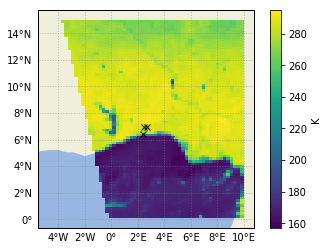

In [4]:
#3. POINTS OF INTEREST

# The following dataset satellite images of a certain region with specific settings (37GHz band, Horizontal Polarization, Ascending recording )
# ds = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_H_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-A_2010.nc')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
# get a mesh of the coordinates in grid's projection
xi, yi = np.meshgrid(ds.x, ds.y)

# the chosen projection is not (yet) supported by caropy.crs, so we need to do the transformation ourselves for now. 
# No biggy, here we go

# define the proj4string belonging to the grids you are downloading. You can find these in a downloaded sample 
# under the variable/attribute crs.proj4text. Here we simply copy-paste that.
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')

loni, lati = pyproj.transform(proj_in, proj_out, xi, yi)
# now drape the data on the map
p = ax.pcolormesh(loni, lati, ds['TB'][1].values, transform=ccrs.PlateCarree())

# Ouémé delta 3 point calibration method - this is the current method that I'm testing.
points_interest = [(2.43, 6.43),  #wet calibration - always covered in water (lake Nokoué)             
                   (2.69936, 6.90851), #bonou dry calibration
                   (2.44936, 6.90851) #bonou measurement cell
                  ]

# points_interest = [(2.43, 6.43),  #wet calibration - always covered in water (lake Nokoué)
                   
#                    (2.25, 6.57),  #dry calibration 1 - never affected by "fluvial" inundations
#                    (2.43, 6.55),  #measurement cell 1 - sometimes affected, real point of interest
                   
#                    (2.25, 6.82),  #dry calibration 2
#                    (2.43, 6.80),  #measurement cell 2
                   
#                    (2.25, 7.40),  #dry calibration 3 (7.07 normally)
#                    (2.43, 7.05),  #measurement cell 3
                   
#                    (2.25, 7.40),  #dry calibration 4 (7.32 normally)
#                    (2.43, 7.30),   #measurement cell 4
                   
#                    (2.69936, 6.90851), #bonou dry calibration
#                    (2.44936, 6.90851) #bonou measurement cell
#                   ]


# # Ouémé gaging station Hounkpe and Badou (2007)
# points_interest = [(2.4406387000000223, 6.893251099999999),
#                    (2.2999999999999545, 7.099999999999999),
#                    (2.4851462999999967, 8.0335995),
#                    (2.0499999999999545, 7.566667)
# ]

#Some coding to visualise the area. 
ax = plt.axes(projection=ccrs.PlateCarree())
ax = nsidc.plot_points(ax, points_interest, marker='x', color='k', linewidth=0., transform=ccrs.PlateCarree())
plt.colorbar(p, label='K')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Gracefully close ds
ds.close()

In [5]:
# ds_37ghz_25km_H_D

In [6]:
#4. COORDINATE SYSTEM PROJECTIONS
#Transforming the coordinate system. The data is available from a Measures dataset by NASA with a weird projection system
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'

# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)


In [7]:
# ds_37ghz_25km_H_D

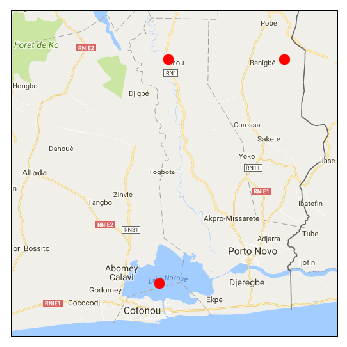

In [8]:
# 5.VISUALISE POINTS OF INTEREST
# first have a look at the points
osm_tiles = moa()
x, y = zip(*points_interest)

plt.figure(figsize=(6, 6))

# Use the tile's projection for the underlying map.
ax = plt.axes(projection=osm_tiles.crs)

# Add the tiles at zoom level 10.
ax.add_image(osm_tiles, 10)
ax.plot(x, y, color='r', marker='.', markersize=20, linewidth=0., transform=ccrs.PlateCarree())

plt.show()

# Loading Brightness Temperature Data 2010

In [9]:
#6. LOAD AND MODIFY TB (BRIGHTNESS TEMPERATURE) TIMESERIES

points_x, points_y = zip(*points_xy)

# Loading the data in x-y coordinates
ts_37ghz_25km_H_A = ds_37ghz_25km_H_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_37ghz_25km_H_D = ds_37ghz_25km_H_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_37ghz_25km_V_A = ds_37ghz_25km_V_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_37ghz_25km_V_D = ds_37ghz_25km_V_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_89ghz_3km_H_A = ds_89ghz_3km_H_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# ts_89ghz_3km_V_A = ds_89ghz_3km_V_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')

# Fill up the NaN entries in the raw data series with values to obtain daily consistency (and optionally plot):

#----------values_37ghz_25km_H_A----------------------------------------------------------------------------------
# plt.figure(figsize=(14,6))
values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))
    
TB_37ghz_25km_H_A_wet= pd.DataFrame(values_37ghz_25km_H_A[0])
TB_37ghz_25km_H_A_wet.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_A_wet_ma = TB_37ghz_25km_H_A_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_wet

TB_37ghz_25km_H_A_dry= pd.DataFrame(values_37ghz_25km_H_A[1])
TB_37ghz_25km_H_A_dry.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_A_dry_ma = TB_37ghz_25km_H_A_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_25km_H_A_measurement= pd.DataFrame(values_37ghz_25km_H_A[2])
TB_37ghz_25km_H_A_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_A_measurement_ma = TB_37ghz_25km_H_A_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement

    
#----------values_37ghz_25km_H_D----------------------------------------------------------------------------------
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
values_37ghz_25km_H_D = ts_37ghz_25km_H_D['TB'].values
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))

TB_37ghz_25km_H_D_wet= pd.DataFrame(values_37ghz_25km_H_D[0])
TB_37ghz_25km_H_D_wet.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_wet_ma = TB_37ghz_25km_H_D_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet

TB_37ghz_25km_H_D_dry= pd.DataFrame(values_37ghz_25km_H_D[1])
TB_37ghz_25km_H_D_dry.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_dry_ma = TB_37ghz_25km_H_D_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_H_D_measurement= pd.DataFrame(values_37ghz_25km_H_D[2])
TB_37ghz_25km_H_D_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma = TB_37ghz_25km_H_D_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#----------values_37ghz_25km_V_A----------------------------------------------------------------------------------
# plt.figure(figsize=(14,6))
values_37ghz_25km_V_A = ts_37ghz_25km_V_A['TB'].values
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))
    
TB_37ghz_25km_V_A_wet= pd.DataFrame(values_37ghz_25km_V_A[0])
TB_37ghz_25km_V_A_wet.fillna(method='bfill',inplace=True)
TB_37ghz_25km_V_A_wet_ma = TB_37ghz_25km_V_A_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_wet

TB_37ghz_25km_V_A_dry= pd.DataFrame(values_37ghz_25km_V_A[1])
TB_37ghz_25km_V_A_dry.fillna(method='bfill',inplace=True)
TB_37ghz_25km_V_A_dry_ma = TB_37ghz_25km_V_A_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_25km_V_A_measurement= pd.DataFrame(values_37ghz_25km_V_A[2])
TB_37ghz_25km_V_A_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_25km_V_A_measurement_ma = TB_37ghz_25km_V_A_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement


#----------values_37ghz_25km_V_D----------------------------------------------------------------------------------
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
values_37ghz_25km_V_D = ts_37ghz_25km_V_D['TB'].values
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))

TB_37ghz_25km_V_D_wet= pd.DataFrame(values_37ghz_25km_V_D[0])
TB_37ghz_25km_V_D_wet.fillna(method='bfill',inplace=True)
TB_37ghz_25km_V_D_wet_ma = TB_37ghz_25km_V_D_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet

TB_37ghz_25km_V_D_dry= pd.DataFrame(values_37ghz_25km_V_D[1])
TB_37ghz_25km_V_D_dry.fillna(method='bfill',inplace=True)
TB_37ghz_25km_V_D_dry_ma = TB_37ghz_25km_V_D_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_V_D_measurement= pd.DataFrame(values_37ghz_25km_V_D[2])
TB_37ghz_25km_V_D_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_25km_V_D_measurement_ma = TB_37ghz_25km_V_D_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#----------values_89ghz_3km_H_A----------------------------------------------------------------------------------
# plt.figure(figsize=(14,6))
values_89ghz_3km_H_A = ts_89ghz_3km_H_A['TB'].values
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))
    
TB_89ghz_3km_H_A_wet= pd.DataFrame(values_89ghz_3km_H_A[0])
TB_89ghz_3km_H_A_wet.fillna(method='bfill',inplace=True)
TB_89ghz_3km_H_A_wet_ma = TB_89ghz_3km_H_A_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_wet

TB_89ghz_3km_H_A_dry= pd.DataFrame(values_89ghz_3km_H_A[1])
TB_89ghz_3km_H_A_dry.fillna(method='bfill',inplace=True)
TB_89ghz_3km_H_A_dry_ma = TB_89ghz_3km_H_A_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_89ghz_3km_H_A_measurement= pd.DataFrame(values_89ghz_3km_H_A[2])
TB_89ghz_3km_H_A_measurement.fillna(method='bfill',inplace=True)
TB_89ghz_3km_H_A_measurement_ma = TB_89ghz_3km_H_A_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement

print('done')

C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  
C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  import sys
C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  
C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  # Remove the CWD from sys.path while we load stuff.


done


# WET CALIBRATION VS. DRY CALIBRATION VS. MEASUREMENT CELL

Text(0,0.5,'Brightness Temperature (K)')

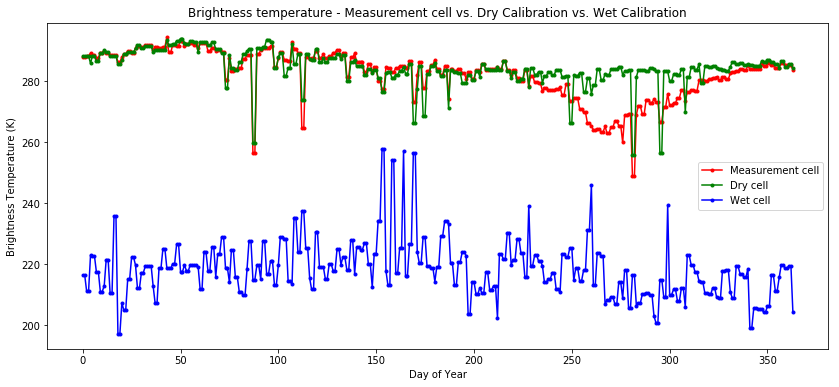

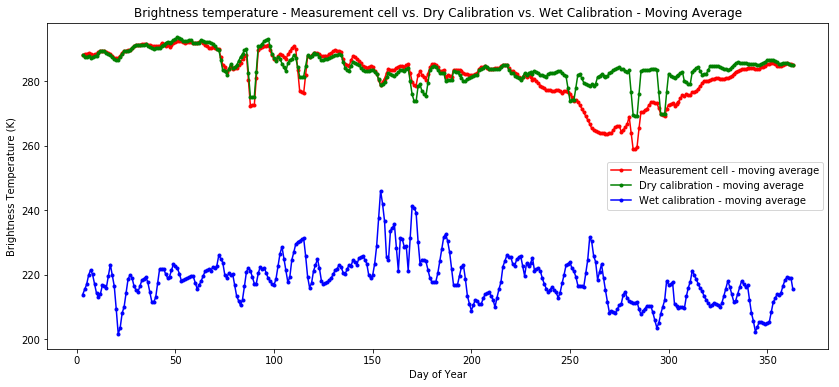

In [18]:
# PLOT WET CALIBRATION VS. DRY CALIBRATION VS. MEASUREMENT CELL

#----------ORIGINAL----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
for n in range(1):
# for n in range(len(1)): #len(TB_37ghz_25km_H_A_measurement)
    plt.plot(TB_37ghz_25km_H_A_measurement, marker='.', color='red', label = 'Measurement cell')
    plt.plot(TB_37ghz_25km_H_A_dry, marker='.', color='green', label = 'Dry cell')
    plt.plot(TB_37ghz_25km_H_A_wet, marker='.', color='blue', label = 'Wet cell')
    
    
# red_patch = mpatches.Patch(color='red', label='Measurement cell')
# green_patch = mpatches.Patch(color='green', label='Dry calibration')
# blue_patch = mpatches.Patch(color='blue', label='Wet calibration')
    
# plt.legend(handles=[red_patch,green_patch,blue_patch])
plt.legend(loc='best')
plt.title('Brightness temperature - Measurement cell vs. Dry Calibration vs. Wet Calibration')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')   
    
#----------MOVING AVERAGE----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
for n in range(1):
    plt.plot(TB_37ghz_25km_H_A_measurement_ma, marker='.', color='red', label = 'Measurement cell - moving average')
    plt.plot(TB_37ghz_25km_H_A_dry_ma, marker='.', color='green', label = 'Dry calibration - moving average')
    plt.plot(TB_37ghz_25km_H_A_wet_ma, marker='.', color='blue', label = 'Wet calibration - moving average')


plt.legend(loc='best')
plt.title('Brightness temperature - Measurement cell vs. Dry Calibration vs. Wet Calibration - Moving Average')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)') 

#----------TABLE----------------------------------------------------------------------------------------
#np.mean(TB_37ghz_25km_H_A_measurement)



# ASCENDING VS. DESCENDING NODE

Text(0,0.5,'Brightness Temperature (K)')

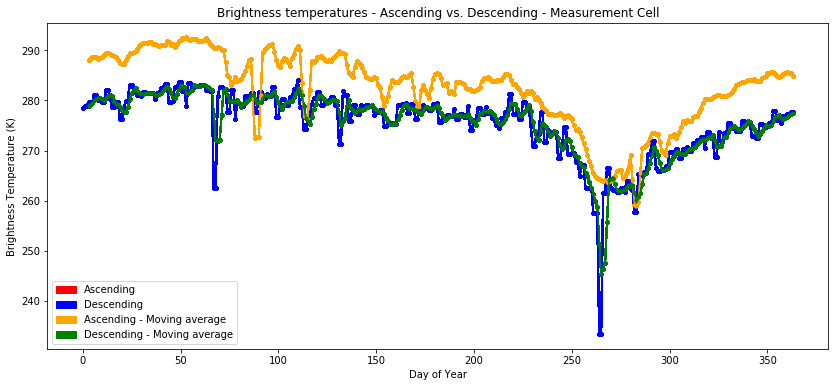

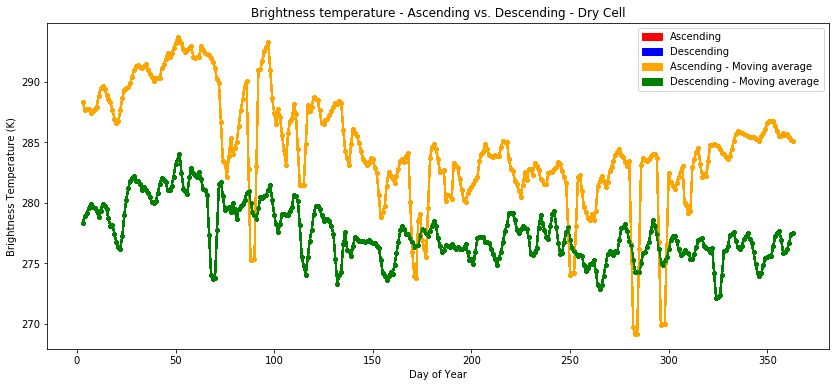

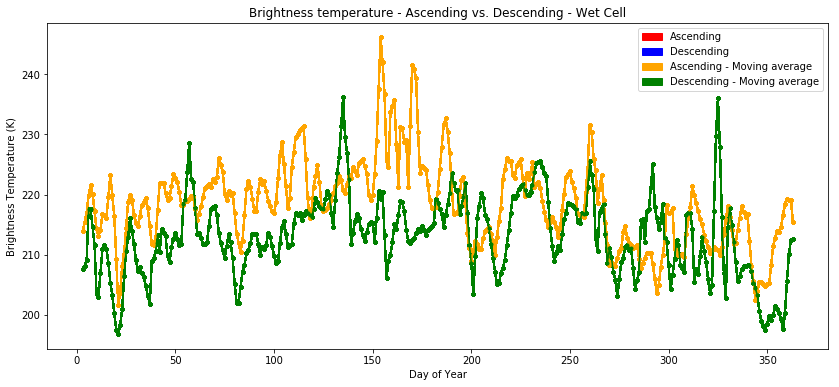

In [19]:
# PLOT ASCENDING VS. DESCENDING
# Ascending node: 1:30 PM LT overpass, South to North #https://nsidc.org/data/modis/terra_aqua_differences
# Descending node: 10:30 AM LT overpass, North to South

from sklearn.metrics import mean_squared_error

#----------MEASUREMENT CELL----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_measurement, marker='.', color='red')#, label='37GHz, Ascending, Measurement cell'
    plt.plot(TB_37ghz_25km_H_D_measurement, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_measurement_ma, marker='.', color='orange')
    plt.plot(TB_37ghz_25km_H_D_measurement_ma, marker='.', color='green')
    
red_patch = mpatches.Patch(color='red', label='Ascending')
blue_patch = mpatches.Patch(color='blue', label='Descending')
orange_patch = mpatches.Patch(color='orange', label='Ascending - Moving average')
green_patch = mpatches.Patch(color='green', label='Descending - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperatures - Ascending vs. Descending - Measurement Cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')

# rms = np.sqrt(mean_squared_error(TB_37ghz_25km_H_A_measurement, TB_37ghz_25km_H_D_measurement))
# print(rms)


#----------DRY CALIBRATION----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_dry, marker='.', color='red')#, label='37GHz, Ascending, Measurement cell'
#     plt.plot(TB_37ghz_25km_H_D_dry, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_dry_ma, marker='.', color='orange')
    plt.plot(TB_37ghz_25km_H_D_dry_ma, marker='.', color='green')

red_patch = mpatches.Patch(color='red', label='Ascending')
blue_patch = mpatches.Patch(color='blue', label='Descending')
orange_patch = mpatches.Patch(color='orange', label='Ascending - Moving average')
green_patch = mpatches.Patch(color='green', label='Descending - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperature - Ascending vs. Descending - Dry Cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')




#----------WET CALIBRATION----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_wet, marker='.', color='red')#, label='37GHz, Ascending, Measurement cell'
#     plt.plot(TB_37ghz_25km_H_D_wet, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_wet_ma, marker='.', color='orange')
    plt.plot(TB_37ghz_25km_H_D_wet_ma, marker='.', color='green')

red_patch = mpatches.Patch(color='red', label='Ascending')
blue_patch = mpatches.Patch(color='blue', label='Descending')
orange_patch = mpatches.Patch(color='orange', label='Ascending - Moving average')
green_patch = mpatches.Patch(color='green', label='Descending - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperature - Ascending vs. Descending - Wet Cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')

# HORIZONTAL VS. VERTICAL POLARIZATION

Text(0,0.5,'Brightness Temperature (K)')

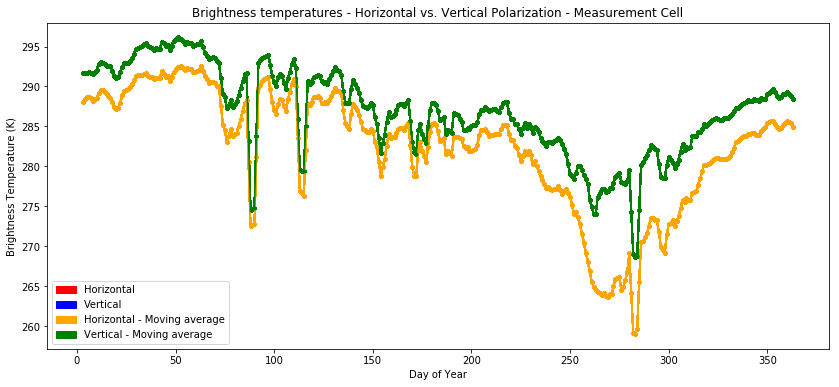

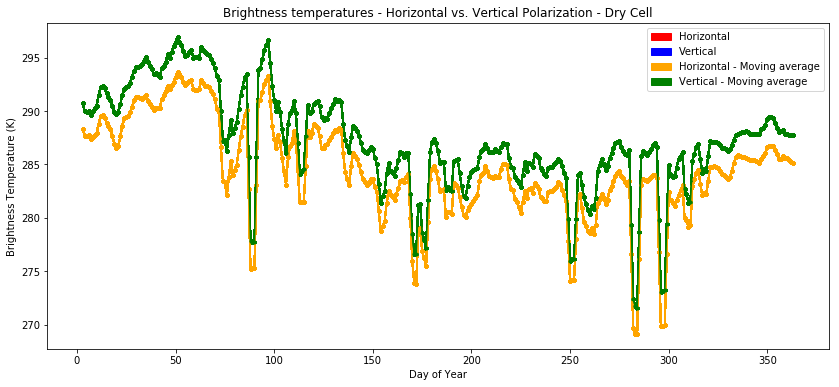

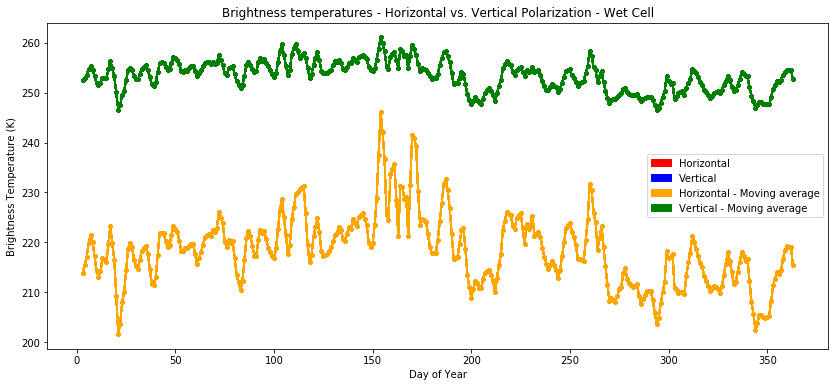

In [20]:
# PLOT HORIZONTAL VS. VERTICAL POLARIZATION

#----------MEASUREMENT CELL----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))

for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_measurement, marker='.', color='red')
#     plt.plot(TB_37ghz_25km_V_A_measurement, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_measurement_ma, marker='.', color='orange')
    plt.plot(TB_37ghz_25km_V_A_measurement_ma, marker='.', color='green')
    
red_patch = mpatches.Patch(color='red', label='Horizontal')
blue_patch = mpatches.Patch(color='blue', label='Vertical')
orange_patch = mpatches.Patch(color='orange', label='Horizontal - Moving average')
green_patch = mpatches.Patch(color='green', label='Vertical - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperatures - Horizontal vs. Vertical Polarization - Measurement Cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')


#----------DRY CALIBRATION----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_dry, marker='.', color='red')#, label='37GHz, Ascending, Measurement cell'
#     plt.plot(TB_37ghz_25km_V_A_dry, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_dry_ma, marker='.', color='orange')
    plt.plot(TB_37ghz_25km_V_A_dry_ma, marker='.', color='green')

red_patch = mpatches.Patch(color='red', label='Horizontal')
blue_patch = mpatches.Patch(color='blue', label='Vertical')
orange_patch = mpatches.Patch(color='orange', label='Horizontal - Moving average')
green_patch = mpatches.Patch(color='green', label='Vertical - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperatures - Horizontal vs. Vertical Polarization - Dry Cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')


#----------WET CALIBRATION----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_wet, marker='.', color='red')#, label='37GHz, Ascending, Measurement cell'
#     plt.plot(TB_37ghz_25km_V_A_wet, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_wet_ma, marker='.', color='orange')
    plt.plot(TB_37ghz_25km_V_A_wet_ma, marker='.', color='green')

red_patch = mpatches.Patch(color='red', label='Horizontal')
blue_patch = mpatches.Patch(color='blue', label='Vertical')
orange_patch = mpatches.Patch(color='orange', label='Horizontal - Moving average')
green_patch = mpatches.Patch(color='green', label='Vertical - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperatures - Horizontal vs. Vertical Polarization - Wet Cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')

# 37 GHz vs. 89 GHz

Text(0,0.5,'Brightness Temperature (K)')

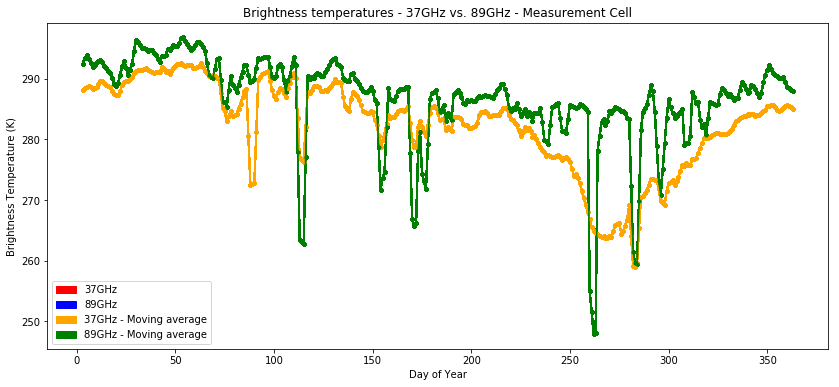

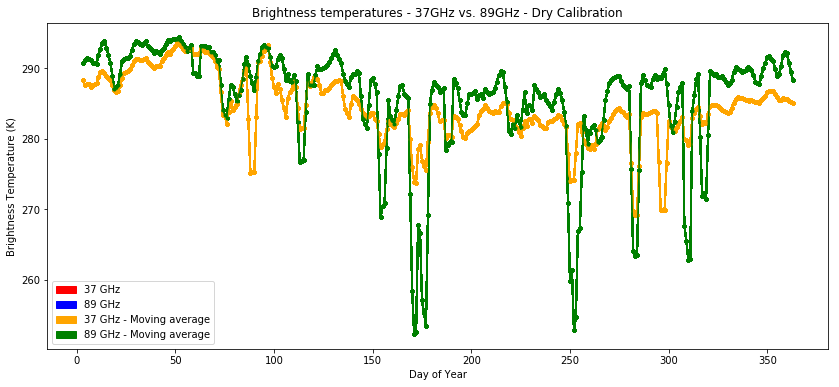

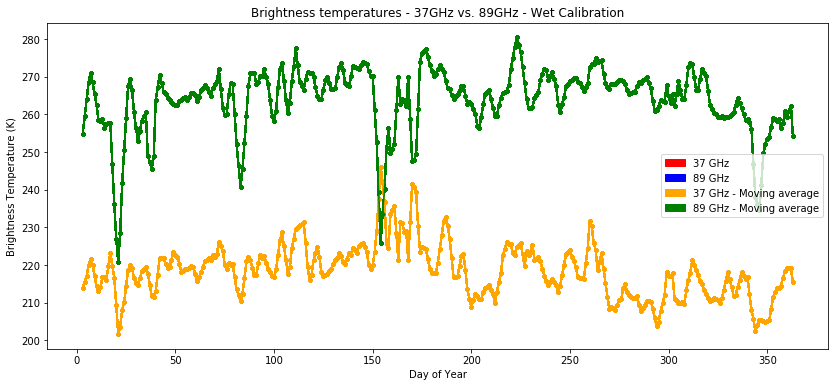

In [21]:
# PLOT 37GHz. vs. 89 GHz.


#----------MEASUREMENT CELL----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_measurement, marker='.', color='red')
#     plt.plot(TB_89ghz_3km_H_A_measurement, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_measurement_ma, marker='.', color='orange')
    plt.plot(TB_89ghz_3km_H_A_measurement_ma, marker='.', color='green')
    
red_patch = mpatches.Patch(color='red', label='37GHz')
blue_patch = mpatches.Patch(color='blue', label='89GHz')
orange_patch = mpatches.Patch(color='orange', label='37GHz - Moving average')
green_patch = mpatches.Patch(color='green', label='89GHz - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperatures - 37GHz vs. 89GHz - Measurement Cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')


#----------DRY CALIBRATION----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))

# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_dry, marker='.', color='red')
#     plt.plot(TB_89ghz_3km_H_A_dry, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_dry_ma, marker='.', color='orange')
    plt.plot(TB_89ghz_3km_H_A_dry_ma, marker='.', color='green')

red_patch = mpatches.Patch(color='red', label='37 GHz')
blue_patch = mpatches.Patch(color='blue', label='89 GHz')
orange_patch = mpatches.Patch(color='orange', label='37 GHz - Moving average')
green_patch = mpatches.Patch(color='green', label='89 GHz - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperatures - 37GHz vs. 89GHz - Dry Calibration')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')


#----------WET CALIBRATION----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_wet, marker='.', color='red')
#     plt.plot(TB_89ghz_3km_H_A_wet, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_wet_ma, marker='.', color='orange')
    plt.plot(TB_89ghz_3km_H_A_wet_ma, marker='.', color='green')

red_patch = mpatches.Patch(color='red', label='37 GHz')
blue_patch = mpatches.Patch(color='blue', label='89 GHz')
orange_patch = mpatches.Patch(color='orange', label='37 GHz - Moving average')
green_patch = mpatches.Patch(color='green', label='89 GHz - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperatures - 37GHz vs. 89GHz - Wet Calibration')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')

# Load Discharge Data - Bonou 2010

In [22]:
# Discharge data
path = (r"C:\\Users\\908138\\githubdata\\discharge\\bonou.csv")
df = pd.read_csv(path,skiprows=0,delimiter=';')
df.columns = ['doy','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959','1960','1961','1962','1963','1964','1965','1966','1967','1968','1969','1970','1971','1972','1973','1974','1975','1976','1977','1978','1979','1980','1981','1982','1983','1984','1985','1986','1987','1988','1989','1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011']

q_2010 = df[['2010']]
doy = df[['doy']]


# C-M Ratio

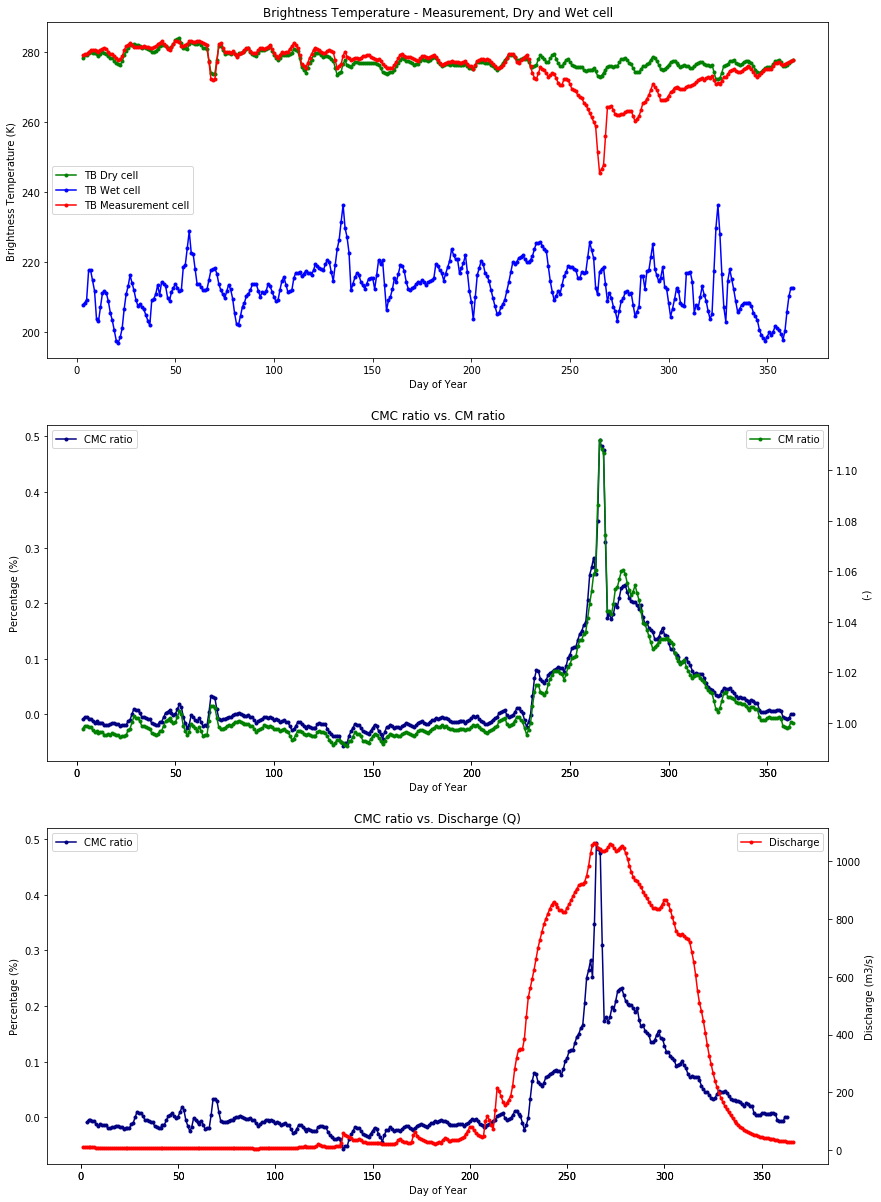

In [23]:
#CM & CMC Ratio
from pylab import figure, show, legend, ylabel, axes, pie, title
import matplotlib.patches as mpatches

#Define cells

C_dry_be = TB_37ghz_25km_H_D_dry_ma #be = best estimate, to distinguish the cells from other (reference) CM(C) ratios
C_wet_be = TB_37ghz_25km_H_D_wet_ma
M_be = TB_37ghz_25km_H_D_measurement_ma

#CM Rato

CM_be = (C_dry_be / M_be)
CMC_be = (C_dry_be - M_be)/(C_dry_be - C_wet_be)


fig = plt.figure(figsize=(14,21))

#---------Plot the individual TB's-------------------------------------
ax1 = fig.add_subplot(311)
ax1.plot(C_dry_be, marker='.', color='g', label = 'TB Dry cell')
ax1.plot(C_wet_be, marker='.', color='b', label = 'TB Wet cell')
ax1.plot(M_be, marker='.', color='r', label = 'TB Measurement cell')
ax1.legend()


plt.title('Brightness Temperature - Measurement, Dry and Wet cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')

#-------Plot the CM Ratio vs. CMC Ratio----------------------------------
ax2 = fig.add_subplot(312)
plt.title('CMC ratio vs. CM ratio')
plt.xlabel('Day of Year')
plt.ylabel('Percentage (%)')
ax2.plot(CMC_be,marker='.', color='navy', label = 'CMC ratio')
ax2.legend(loc=2)

ax3 = fig.add_subplot(312, frameon = False)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
plt.ylabel('(-)')
ax3.plot(CM_be,marker='.', color='g', label = 'CM ratio')
ax3.legend()

# navy_patch = mpatches.Patch(color='navy', label='CM ratio')
# goldenrod_patch = mpatches.Patch(color='goldenrod', label='CMC ratio')
# plt.legend(handles=[navy_patch,goldenrod_patch])

# red_patch = mpatches.Patch(color='red', label='Discharge (m3/s)')
# blue_patch = mpatches.Patch(color='blue', label='C/M/C ratio (%)')
# # green_patch = mpatches.Patch(color='green', label='C/M ratio (-)')
# plt.legend(handles=[red_patch,blue_patch])
# plt.show()


#---------Plot Q vs. CMC Ratio------------------------------------
ax4 = fig.add_subplot(313)
plt.title('CMC ratio vs. Discharge (Q)')
plt.xlabel('Day of Year')
plt.ylabel('Percentage (%)')
ax4.plot(CMC_be,marker='.', color='navy', label = 'CMC ratio')
ax4.legend(loc=2)

ax5 = fig.add_subplot(313, sharex=ax4, frameon=False)
q_dis = ax5.plot(doy,q_2010, linestyle='-', color='red',marker='.', label = 'Discharge')
ax5.yaxis.tick_right()
ax5.yaxis.set_label_position("right")
ylabel("Discharge (m3/s)")
ax5.legend()


# Comparison of all possible CMC Ratio's


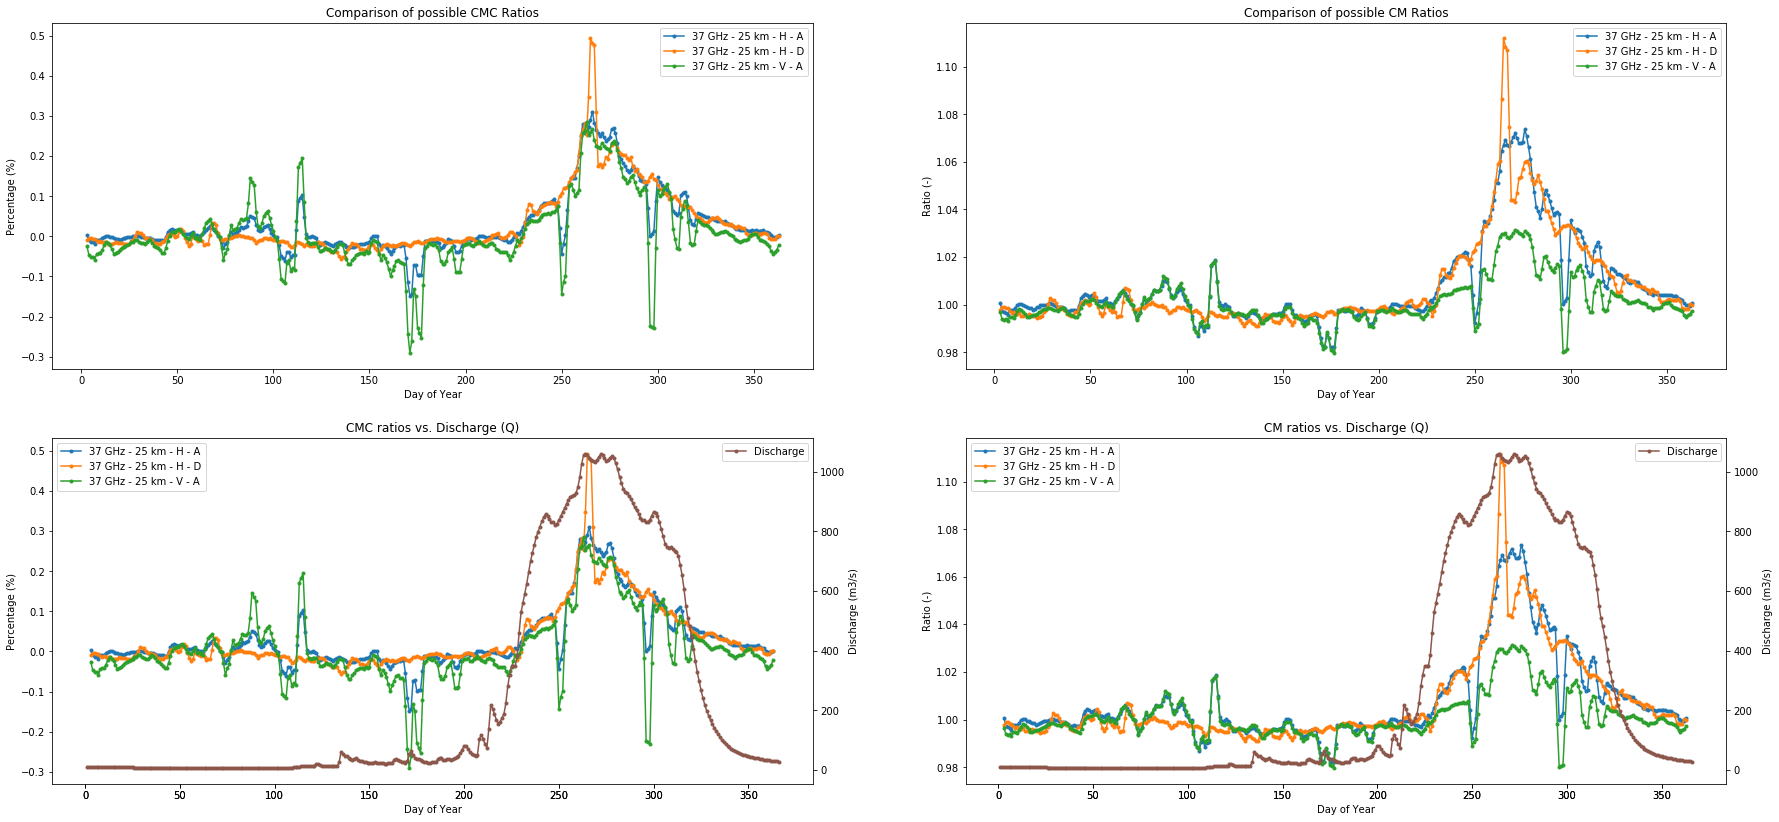

In [24]:
#CM & CMC Ratio
from pylab import figure, show, legend, ylabel, axes, pie, title
import matplotlib.patches as mpatches

#Define possible CMC ratios
CMC_37ghz_25km_H_A = (TB_37ghz_25km_H_A_dry_ma - TB_37ghz_25km_H_A_measurement_ma)/(TB_37ghz_25km_H_A_dry_ma - TB_37ghz_25km_H_A_wet_ma)
CMC_37ghz_25km_H_D = (TB_37ghz_25km_H_D_dry_ma - TB_37ghz_25km_H_D_measurement_ma)/(TB_37ghz_25km_H_D_dry_ma - TB_37ghz_25km_H_D_wet_ma)
CMC_37ghz_25km_V_A = (TB_37ghz_25km_V_A_dry_ma - TB_37ghz_25km_V_A_measurement_ma)/(TB_37ghz_25km_V_A_dry_ma - TB_37ghz_25km_V_A_wet_ma)
CMC_37ghz_25km_V_D = (TB_37ghz_25km_V_D_dry_ma - TB_37ghz_25km_V_D_measurement_ma)/(TB_37ghz_25km_V_D_dry_ma - TB_37ghz_25km_V_D_wet_ma)

#Define possible CM ratios
CM_37ghz_25km_H_A = (TB_37ghz_25km_H_A_dry_ma/TB_37ghz_25km_H_A_measurement_ma)
CM_37ghz_25km_H_D = (TB_37ghz_25km_H_D_dry_ma/TB_37ghz_25km_H_D_measurement_ma)
CM_37ghz_25km_V_A = (TB_37ghz_25km_V_A_dry_ma/TB_37ghz_25km_V_A_measurement_ma)
CM_37ghz_25km_V_D = (TB_37ghz_25km_V_D_dry_ma/TB_37ghz_25km_V_D_measurement_ma)

fig = plt.figure(figsize=(30,14))

#---------Plot the possible CMC ratio's---------------------------------------------------------------------
ax1 = fig.add_subplot(221)
ax1.plot(CMC_37ghz_25km_H_A, marker='.', color='C0', label = '37 GHz - 25 km - H - A')
ax1.plot(CMC_37ghz_25km_H_D, marker='.', color='C1', label = '37 GHz - 25 km - H - D')
ax1.plot(CMC_37ghz_25km_V_A, marker='.', color='C2', label = '37 GHz - 25 km - V - A')
# ax1.plot(CMC_37ghz_25km_V_D, marker='.', color='C3', label = '37 GHz - 25 km - V - D')
ax1.legend()

plt.title('Comparison of possible CMC Ratios')
plt.xlabel('Day of Year')
plt.ylabel('Percentage (%)')

#---------Again plot all possible CMC ratio's---------------------------------------------------------------------
ax2 = fig.add_subplot(223)
plt.title('CMC ratios vs. Discharge (Q)')
plt.xlabel('Day of Year')
plt.ylabel('Percentage (%)')
ax2.plot(CMC_37ghz_25km_H_A, marker='.', color='C0', label = '37 GHz - 25 km - H - A')
ax2.plot(CMC_37ghz_25km_H_D, marker='.', color='C1', label = '37 GHz - 25 km - H - D')
ax2.plot(CMC_37ghz_25km_V_A, marker='.', color='C2', label = '37 GHz - 25 km - V - A')
# ax2.plot(CMC_37ghz_25km_V_D, marker='.', color='C3', label = '37 GHz - 25 km - V - D')
ax2.legend(loc=2)

# Add the discharge data
ax3 = fig.add_subplot(223, sharex=ax2, frameon=False)
q_dis = ax3.plot(doy,q_2010, linestyle='-', color='C5',marker='.', label = 'Discharge')
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ylabel("Discharge (m3/s)")
ax3.legend()

#---------Plot all possible CM ratios---------------------------------------------------------------------
ax4 = fig.add_subplot(222)
ax4.plot(CM_37ghz_25km_H_A, marker='.', color='C0', label = '37 GHz - 25 km - H - A')
ax4.plot(CM_37ghz_25km_H_D, marker='.', color='C1', label = '37 GHz - 25 km - H - D')
ax4.plot(CM_37ghz_25km_V_A, marker='.', color='C2', label = '37 GHz - 25 km - V - A')
# ax4.plot(CM_37ghz_25km_V_D, marker='.', color='C3', label = '37 GHz - 25 km - V - D')
ax4.legend()

plt.title('Comparison of possible CM Ratios')
plt.xlabel('Day of Year')
plt.ylabel('Ratio (-)')

#---------Again plot all possible CM ratios---------------------------------------------------------------------
ax5 = fig.add_subplot(224)
plt.title('CM ratios vs. Discharge (Q)')
plt.xlabel('Day of Year')
plt.ylabel('Ratio (-)')
ax5.plot(CM_37ghz_25km_H_A, marker='.', color='C0', label = '37 GHz - 25 km - H - A')
ax5.plot(CM_37ghz_25km_H_D, marker='.', color='C1', label = '37 GHz - 25 km - H - D')
ax5.plot(CM_37ghz_25km_V_A, marker='.', color='C2', label = '37 GHz - 25 km - V - A')
# ax5.plot(CM_37ghz_25km_V_D, marker='.', color='C3', label = '37 GHz - 25 km - V - D')
ax5.legend(loc=2)

# Add the discharge data
ax6 = fig.add_subplot(224, sharex=ax5, frameon=False)
q_dis = ax6.plot(doy,q_2010, linestyle='-', color='C5',marker='.', label = 'Discharge')
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")
ylabel("Discharge (m3/s)")
ax6.legend()